#  Programming assignment 6: Autoencoders

Today we're going to train deep autoencoders and apply them to faces and similar images search.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Import stuff

In [1]:
import sys
sys.path.append("..")
import grading

In [2]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import download_utils
import keras_utils
import numpy as np

Using TensorFlow backend.


In [3]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

# Load dataset
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [4]:
# we downloaded them for you, just link them here
download_utils.link_week_4_resources()

In [5]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [6]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


3804

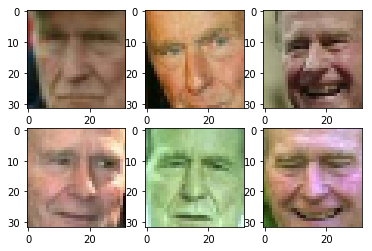

In [7]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

# Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train these models.

<img src="images/autoencoder.png" style="width:30%">

# First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

<img src="images/pca.png" style="width:30%">

PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [13]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    # ENCODER
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder
    
    # DECODER
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model:

In [9]:
s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15



In [8]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

PCA MSE: 0.00662025283746


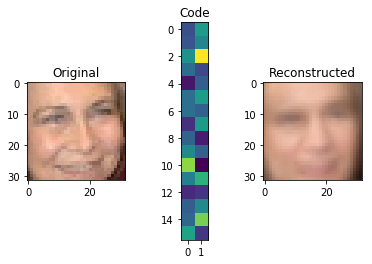

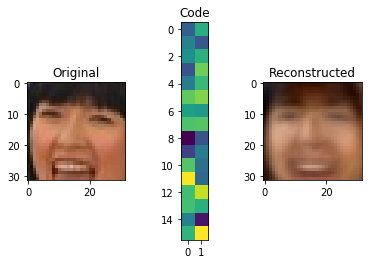

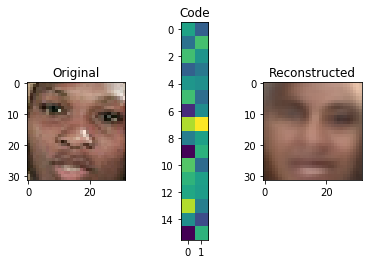

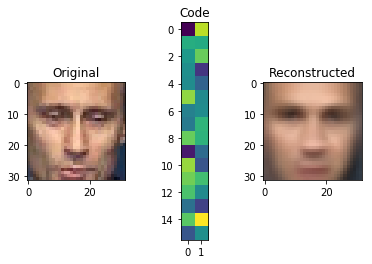

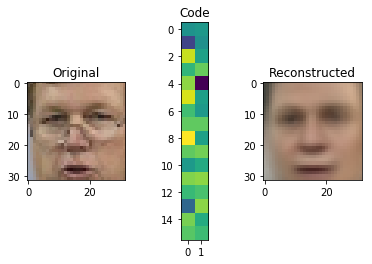

In [11]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

# Going deeper: convolutional autoencoder

PCA is neat but surely we can do better. This time we want you to build a deep convolutional autoencoder by... stacking more layers.

## Encoder

The **encoder** part is pretty standard, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (`code_size`).

We recommend to use `activation='elu'` for all convolutional and dense layers.

We recommend to repeat (conv, pool) 4 times with kernel size (3, 3), `padding='same'` and the following numbers of output channels: `32, 64, 128, 256`.

Remember to flatten (`L.Flatten()`) output before adding the last dense layer!

## Decoder

For **decoder** we will use so-called "transpose convolution". 

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in encoder. We had a glimpse of it during week 3 (watch [this video](https://www.coursera.org/learn/intro-to-deep-learning/lecture/auRqf/a-glimpse-of-other-computer-vision-tasks) starting at 5:41).

Here's how "transpose convolution" works:

<img src="images/transpose_conv.jpg" style="width:60%">

In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in Keras like this:
```python
L.Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
```

Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" `L.Flatten()` in encoder.

Now we're ready to undo (conv, pool) pairs. For this we need to stack 4 `L.Conv2DTranspose` layers with the following numbers of output channels: `128, 64, 32, 3`. Each of these layers will learn to "undo" (conv, pool) pair in encoder. For the last `L.Conv2DTranspose` layer use `activation=None` because that is our final image.

In [9]:
X_train.shape

(11828, 32, 32, 3)

In [10]:
# Let's play around with transpose convolution on examples first
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    with tf.Session() as session:
        result = session.run(conv)
        print("input:")
        print(x[0, :, :, 0])
        print("filter:")
        print(f[:, :, 0, 0])
        print("output:")
        print(result[0, :, :, 0])
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[ 1.  2.]
 [ 3.  4.]]
filter:
[[ 1.  1.]
 [ 1.  1.]]
output:
[[ 1.  1.  2.  2.]
 [ 1.  1.  2.  2.]
 [ 3.  3.  4.  4.]
 [ 3.  3.  4.  4.]]
Transpose convolution test for img_size=2, filter_size=3:
input:
[[ 1.  2.]
 [ 3.  4.]]
filter:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
output:
[[  1.   1.   3.   2.]
 [  1.   1.   3.   2.]
 [  4.   4.  10.   6.]
 [  3.   3.   7.   4.]]
Transpose convolution test for img_size=4, filter_size=2:
input:
[[  1.   2.   3.   4.]
 [  5.   6.   7.   8.]
 [  9.  10.  11.  12.]
 [ 13.  14.  15.  16.]]
filter:
[[ 1.  1.]
 [ 1.  1.]]
output:
[[  1.   1.   2.   2.   3.   3.   4.   4.]
 [  1.   1.   2.   2.   3.   3.   4.   4.]
 [  5.   5.   6.   6.   7.   7.   8.   8.]
 [  5.   5.   6.   6.   7.   7.   8.   8.]
 [  9.   9.  10.  10.  11.  11.  12.  12.]
 [  9.   9.  10.  10.  11.  11.  12.  12.]
 [ 13.  13.  14.  14.  15.  15.  16.  16.]
 [ 13.  13.  14.  14.  15.  15.  16.  16.]]
Transpose c

## Basic autoencoder

In [11]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # Encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size*32, activation='relu'))
    encoder.add(L.Dense(code_size*16, activation='relu'))
    encoder.add(L.Dense(code_size*8, activation='relu'))
    encoder.add(L.Dense(code_size*4, activation='relu'))
    encoder.add(L.Dense(code_size*2, activation='relu'))
    encoder.add(L.Dense(code_size))
    
    # Decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(code_size*2, activation='relu'))
    decoder.add(L.Dense(code_size*4, activation='relu'))
    decoder.add(L.Dense(code_size*8, activation='relu'))
    decoder.add(L.Dense(code_size*16, activation='relu'))
    decoder.add(L.Dense(code_size*32)
    decoder.add(L.Dense(np.prod(img_shape), activation='relu'))
    decoder.add(L.Reshape(img_shape))
    
    return encoder, decoder

## Convolutional autoencoder

**Note**: If you get an error `Input 0 is incompatible with layer conv2d_1: expected ndim=4, found ndim=2
`, it means that the input in the convolution is of $\mathbb{R}^2$, not the expected $\mathbb{R}^4$ (meaning number of examples, height, length, colors).

In [46]:
def build_deep_autoencoder_CNN(img_shape, code_size):
    H,W,C = img_shape
    
    # ENCODER
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(32, (3,3), strides=(1,1), padding="same", activation='relu'))
    encoder.add(L.MaxPooling2D((2,2)))
    encoder.add(L.Conv2D(64, (3,3), strides=(1,1), padding="same", activation='relu'))
    encoder.add(L.MaxPooling2D((2,2)))
    encoder.add(L.Conv2D(128, (3,3), strides=(1,1), padding="same", activation='relu'))
    encoder.add(L.MaxPooling2D((2,2)))
    encoder.add(L.Conv2D(256, (3,3), strides=(1,1), padding="same", activation='relu'))
    encoder.add(L.MaxPooling2D((2,2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))
    
    # DECODER
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(1024))
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, activation='relu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, activation='relu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3,3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

## Implementation

In [47]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    s = reset_tf_session()
    encoder, decoder = build_deep_autoencoder_CNN(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")
s = reset_tf_session()

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [48]:
# Look at encoder and decoder shapes.
# Total number of trainable parameters of encoder and decoder should be close.
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder_CNN(IMG_SHAPE, code_size=32)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
__________

In [49]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              33792     
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 128)         295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 3)         867       
Total para

Convolutional autoencoder training. This will take **1 hour**. You're aiming at ~0.0056 validation MSE and ~0.0054 training MSE.

In [31]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder_CNN(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adam", loss='mse')

Thus:

In [32]:
autoencoder.fit(x=X_train, y=X_train,
                epochs=50,
                validation_data=[X_test, X_test],
                verbose=1,
                initial_epoch=0)

Train on 11828 samples, validate on 1315 samples
Epoch 1/50
11828/11828 [==============================] - 100s - loss: 0.0118 - val_loss: 0.0079
Epoch 2/50
11828/11828 [==============================] - 100s - loss: 0.0074 - val_loss: 0.0071
Epoch 3/50
11828/11828 [==============================] - 101s - loss: 0.0071 - val_loss: 0.0069
Epoch 4/50
11828/11828 [==============================] - 100s - loss: 0.0069 - val_loss: 0.0068
Epoch 5/50
11828/11828 [==============================] - 102s - loss: 0.0068 - val_loss: 0.0067
Epoch 6/50
11828/11828 [==============================] - 102s - loss: 0.0066 - val_loss: 0.0066
Epoch 7/50
11828/11828 [==============================] - 107s - loss: 0.0065 - val_loss: 0.0064
Epoch 8/50
11828/11828 [==============================] - 109s - loss: 0.0064 - val_loss: 0.0063
Epoch 9/50
11828/11828 [==============================] - 110s - loss: 0.0062 - val_loss: 0.0062
Epoch 10/50
11828/11828 [==============================] - 114s - loss: 0.0061

Convolutional autoencoder MSE: 0.0054860112422


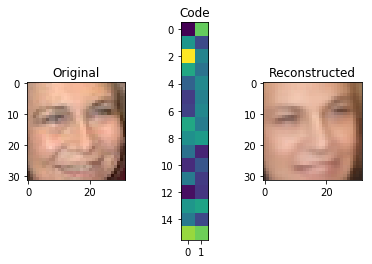

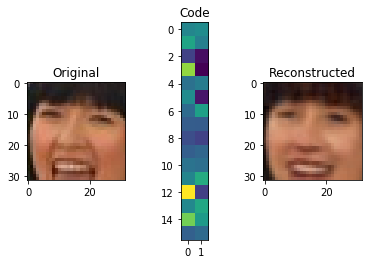

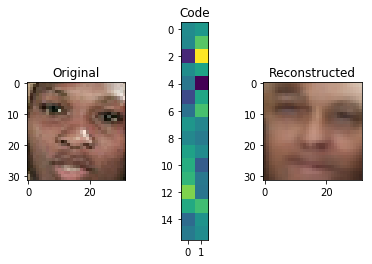

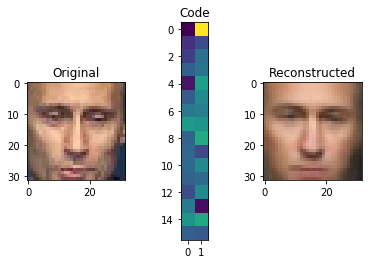

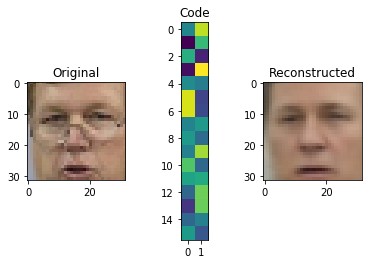

In [33]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [34]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [35]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.0054860112422
0.0054860112422


# Submit to Coursera

In [36]:
from submit import submit_autoencoder
submission = build_deep_autoencoder(IMG_SHAPE, code_size=71)

# token expires every 30 min
COURSERA_TOKEN = "<TOKEN>"
COURSERA_EMAIL = "<EMAIL>"

submit_autoencoder(submission, reconstruction_mse, COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


That's it!

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track on Generative Adversarial Networks or GANs.